# FEATURE SELECTION

In [29]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/Drive')
!ls '/content/Drive/My Drive/UIUC/MLTP/Classification/DATA'

Mounted at /content/Drive
final_test.csv	final_train.csv


In [10]:
train = pd.read_csv('/content/Drive/My Drive/UIUC/MLTP/Classification/DATA/final_train.csv',index_col=0)
test = pd.read_csv('/content/Drive/My Drive/UIUC/MLTP/Classification/DATA/final_test.csv',index_col=0)

In [11]:
train.shape

(168, 148)

In [41]:
y_train = train['class']
x_train = train.drop('class',axis=1)
x_train
print(x_train.shape)
print(y_train.shape)

(168, 147)
(168,)


In [42]:
y_test = test['class']
x_test = test.drop('class',axis=1)
x_test
print(x_test.shape)
print(y_test.shape)

(507, 147)
(507,)


In [22]:
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_train.shape
y_test = le.fit_transform(y_test)
y_test.shape

(507,)

## chi2

BrdIndx          7.710308e-07
Area             1.800333e-06
Round            3.006241e-07
Bright           2.046460e-06
Compact          6.557087e-07
                     ...     
Dens_140         3.751495e-07
Assym_140        3.979005e-07
NDVI_140         1.088302e-06
BordLngth_140    7.644206e-07
GLCM3_140        3.611918e-07
Length: 147, dtype: float64
chi2 picked 37 variables and eliminated the other 110 variables


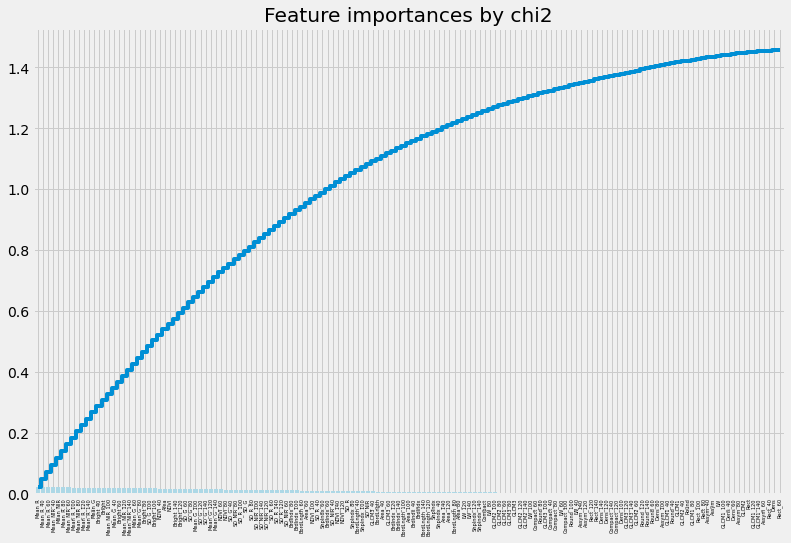

In [19]:
model_chi2 = SelectKBest(chi2, k='all').fit(x_train, y_train)

coef = pd.Series((model_chi2.scores_)/10**7, index = x_train.columns)
print(coef)
print("chi2 picked " + str(sum(coef >= 1.5*10**(-6))) + " variables and eliminated the other " +  str(sum(coef < 1.5*10**(-6))) + " variables")

chi2_feature=[]
for each in range(len(coef)):
  if coef[each] >= 1.5*10**(-6):
    chi2_feature.append(coef.index[each])

plt.style.use('fivethirtyeight')  
names = x_train.columns
importances = np.abs((model_chi2.scores_)/10**3)
feat_names = names
indices = np.argsort(importances)[::-1]  
fig = plt.figure(figsize=(12,8))
plt.title("Feature importances by chi2")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=5)
plt.xlim([-1, len(indices)])
plt.show()

## XGB

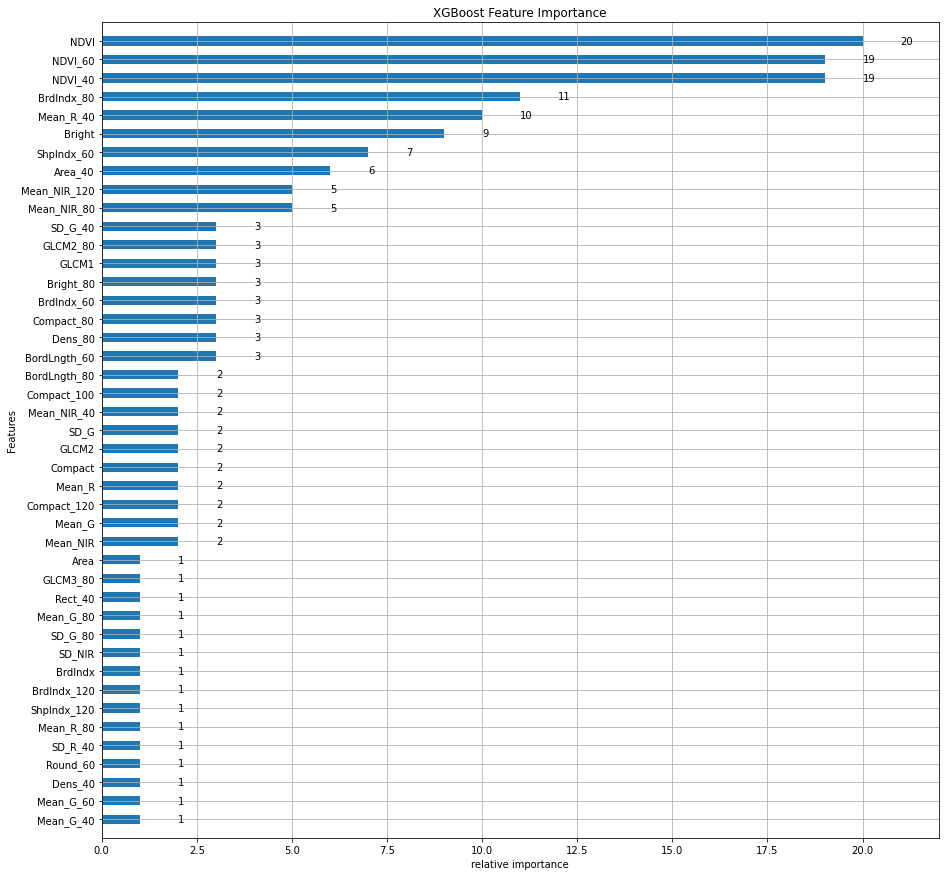

In [16]:
dtrain = xgboost.DMatrix(x_train,y_train)

params = {'max_depth':8, 
         'eta'      :0.02,
         'subsample':0.8,
         'lambda '  :4, 
         'colsample_bytree ':0.9,
         'colsample_bylevel':1,
         'min_child_weight': 10}

XGB_model = xgboost.train(params, dtrain,num_boost_round=20)
XGB_feature = pd.DataFrame(pd.Series(XGB_model.get_fscore()),columns=["feature"])
XGB_feature = XGB_feature.reset_index().rename(columns={'feature':'importance'})

fig, ax = plt.subplots(figsize=(15,15))
xgboost.plot_importance(XGB_model,ax=ax,height = 0.5)
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.show()

## RF

RF picked 38 variables and eliminated the other 109 variables


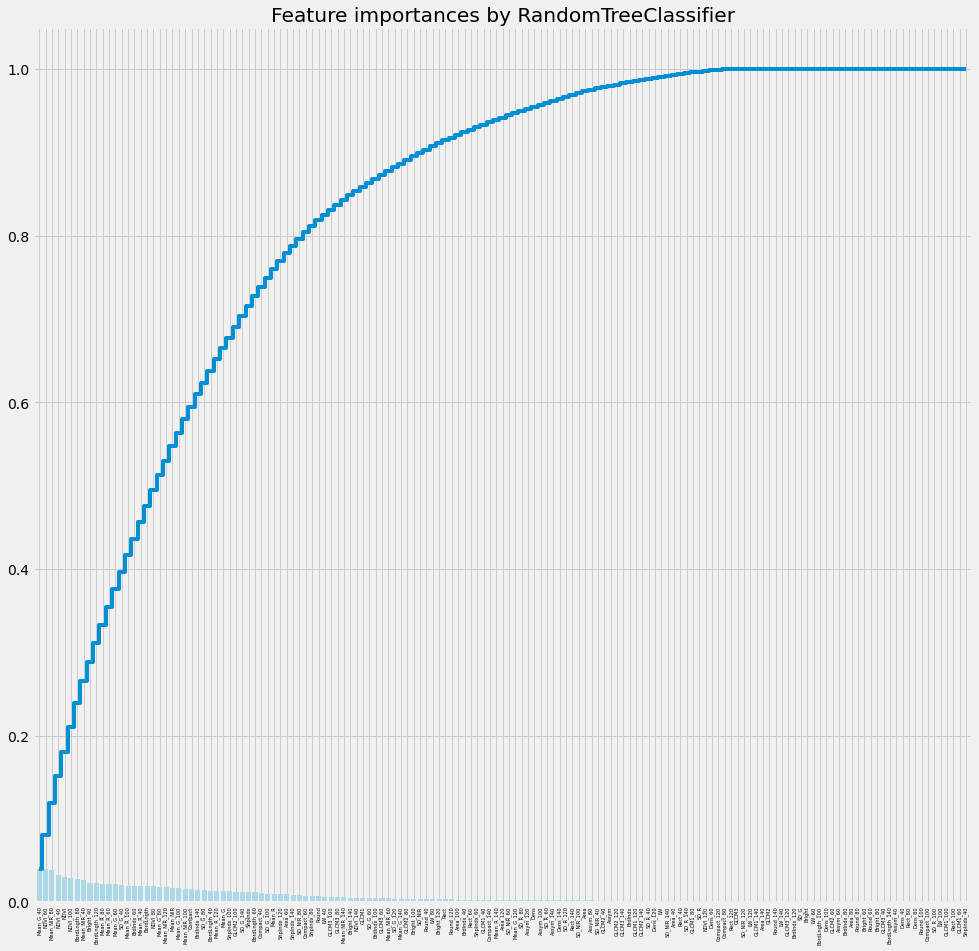

In [20]:
names = x_train.columns
clf=RandomForestClassifier(n_estimators=10,random_state=0)
clf.fit(x_train, y_train) 
#for feature in zip(names, clf.feature_importances_):
#    print(feature)

print("RF picked " + str(sum(clf.feature_importances_ >=0.01)) + " variables and eliminated the other " +  str(sum(clf.feature_importances_ <0.01)) + " variables")
RF_feature=[]
for each in range(len(x_train.columns)):
  if clf.feature_importances_[each] >= 0.01:
    RF_feature.append(x_train.columns[each])

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
importances = clf.feature_importances_
feat_names = names
indices = np.argsort(importances)[::-1]
fig = plt.figure(figsize=(15,15))
plt.title("Feature importances by RandomTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=5)
plt.xlim([-1, len(indices)])
plt.show()

## mult-logistic regression

### CHI2


In [23]:
kappa = []
accuracy = []
f1 = []

#chi2
chi2_x_train = x_train[chi2_feature]
skFold = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)
for train_index, test_index in skFold.split(chi2_x_train,y_train):
    X_train_split, X_test_split=chi2_x_train.iloc[train_index,:], chi2_x_train.iloc[test_index,:]
    y_train_split, y_test_split=y_train[train_index], y_train[test_index]
    LR = LogisticRegression(random_state=0,multi_class = 'multinomial',solver="newton-cg")
    LR.fit(X_train_split, y_train_split)
    kappa.append(cohen_kappa_score(y_test_split, LR.predict(X_test_split)))
    accuracy.append(accuracy_score(y_test_split, LR.predict(X_test_split)))
    f1.append(f1_score(y_test_split, LR.predict(X_test_split),average='micro'))
#input kappa, % correct, precision, and recall
print("kappa score: {}".format(np.mean(kappa)))
print("accuracy: {}".format(np.mean(accuracy)))
print("f1: {}".format(np.mean(f1)))
print("confusion matrix: \n{}".format(confusion_matrix(y_test, LR.predict(x_test[chi2_feature]))))
print("classification report: \n{}".format(classification_report(y_test, LR.predict(x_test[chi2_feature]))))

kappa score: 0.7539104704868871
accuracy: 0.7857142857142857
f1: 0.7857142857142857
confusion matrix: 
[[36  0  0  0  1  2  5  0  1]
 [ 2 25  3 65  1  0  0  1  0]
 [ 0  0 18  1  0  1  0  1  0]
 [ 0  4  3 83  0  0  0  2  1]
 [ 0  0  2  1 63  0  0  0 17]
 [ 0  1  0  0  0 12  0  0  1]
 [ 2  0  0  0  0  1 40  0  2]
 [ 0  0  1  4 12  0  0  3  0]
 [ 0  0  0  0 12  0  4  0 73]]
classification report: 
              precision    recall  f1-score   support

           0       0.90      0.80      0.85        45
           1       0.83      0.26      0.39        97
           2       0.67      0.86      0.75        21
           3       0.54      0.89      0.67        93
           4       0.71      0.76      0.73        83
           5       0.75      0.86      0.80        14
           6       0.82      0.89      0.85        45
           7       0.43      0.15      0.22        20
           8       0.77      0.82      0.79        89

    accuracy                           0.70       507
   mac

In [ ]:
log = LogisticRegression()
log_pa = {
    'penalty': ['l1',' l2', 'elasticnet'],
    'C': np.arange(0.01,31),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'class_weight': ['balanced', None],
    'l1_ratio': [0.001,0.01,0.1]
    # 'max_iter': np.arange(100,1100000,10000)
}

log_grid = GridSearchCV(log, log_pa, cv = 4, scoring = 'f1_weighted')
log_grid.fit(chi2_x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Go

KeyboardInterrupt: ignored

In [ ]:
print('Best cv accuracy: {}' .format(log_grid.best_score_))
print('Test set score:   {}' .format(log_grid.score(chi2_x_train, y_train)))
print('Best parameters:  {}' .format(log_grid.best_params_))

Best cv accuracy: 0.8389137813244956
Test set score:   0.886717856682903
Best parameters:  {'C': 8.01, 'class_weight': None, 'l1_ratio': 0.001, 'penalty': 'elasticnet', 'solver': 'saga'}


(168, 37)
(168,)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


F1_test 0.808571792158977
F1_train 0.8809174411539212
Accuracy_test 0.8154761904761905
Accuracy_train 0.8809523809523809
Precision_test 0.842838246409675
Precision_train 0.8879853638329311
Recall_test 0.8154761904761905
Recall_train 0.8809523809523809


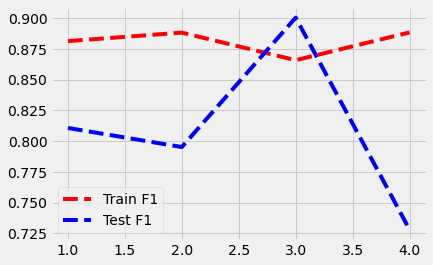

In [ ]:
f1_log_test = []
f1_log_train = []
acc_log_test = []
acc_log_train = []
pre_log_test = []
pre_log_train = []
re_log_test = []
re_log_train = []
x = chi2_x_train
y = y_train
print(x.shape)
print(y.shape)
kf = StratifiedKFold(n_splits=4, random_state=0, shuffle=True)
for train_index, test_index in kf.split(x,y):
    x_train, x_test = x.iloc[train_index,:], x.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    log = LogisticRegression(C = 8.01, penalty = 'elasticnet', solver = 'saga', class_weight= None, l1_ratio= 0.001)

    log.fit(x_train, y_train)
    predicted = log.predict(x_test)

    pred_train = log.predict(x_train)
    
    f1_test = metrics.f1_score(y_test, predicted, average = 'weighted')
    f1_train = metrics.f1_score(y_train, pred_train, average = 'weighted')

    acc_test = metrics.accuracy_score(y_test, predicted)
    acc_train = metrics.accuracy_score(y_train, pred_train)

    pre_test = metrics.precision_score(y_test, predicted, average = 'weighted')
    pre_train = metrics.precision_score(y_train, pred_train, average = 'weighted')

    re_test = metrics.recall_score(y_test, predicted, average = 'weighted')
    re_train = metrics.recall_score(y_train, pred_train, average = 'weighted')

    f1_log_test.append(f1_test)
    f1_log_train.append(f1_train)

    acc_log_test.append(acc_test)   
    acc_log_train.append(acc_train) 

    pre_log_test.append(pre_test)   
    pre_log_train.append(pre_train)

    re_log_test.append(re_test)   
    re_log_train.append(re_train)

print('F1_test',np.mean(f1_log_test))
print('F1_train', np.mean(f1_log_train))
print('Accuracy_test',np.mean(acc_log_test))
print('Accuracy_train', np.mean(acc_log_train))
print('Precision_test',np.mean(pre_log_test))
print('Precision_train', np.mean(pre_log_train))
print('Recall_test',np.mean(re_log_test))
print('Recall_train', np.mean(re_log_train))

log = {
    'Fold': pd.Series([1,2,3,4]),
    'Train_F1': pd.Series(f1_log_train),
    'Test_F1': pd.Series(f1_log_test)
}
log_fitting = pd.DataFrame(log)

plt.plot(log_fitting['Fold'], log_fitting['Train_F1'], 'r--', log_fitting['Fold'], log_fitting['Test_F1'], 'b--')
# plt.ylim((0.40,0.50))
plt.legend(['Train F1', 'Test F1'])
plt.show()

In [ ]:
Counter(y_train)

Counter({0: 14, 1: 25, 2: 15, 3: 23, 4: 29, 5: 15, 6: 16, 7: 14, 8: 17})

In [ ]:
Counter(LR.predict(chi2_x_train))

Counter({0: 13, 1: 26, 2: 15, 3: 23, 4: 34, 5: 15, 6: 17, 7: 11, 8: 14})

### XGB


In [24]:
kappa = []
accuracy = []
f1 = []

#XGB
XGB_x_train = x_train[XGB_feature['index']]
skFold = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)
for train_index, test_index in skFold.split(XGB_x_train,y_train):
    X_train_split, X_test_split=XGB_x_train.iloc[train_index,:], XGB_x_train.iloc[test_index,:]
    y_train_split, y_test_split=y_train[train_index], y_train[test_index]
    LR = LogisticRegression(random_state=0,multi_class = 'multinomial',solver="newton-cg")
    LR.fit(X_train_split, y_train_split)
    kappa.append(cohen_kappa_score(y_test_split, LR.predict(X_test_split)))
    accuracy.append(accuracy_score(y_test_split, LR.predict(X_test_split)))
    f1.append(f1_score(y_test_split, LR.predict(X_test_split),average='micro'))
#input kappa, % correct, precision, and recall
print("kappa score: {}".format(np.mean(kappa)))
print("accuracy: {}".format(np.mean(accuracy)))
print("f1: {}".format(np.mean(f1)))
print("confusion matrix: \n{}".format(confusion_matrix(y_test, LR.predict(x_test[XGB_feature['index']]))))
print("classification report: \n{}".format(classification_report(y_test, LR.predict(x_test[XGB_feature['index']]))))

kappa score: 0.7685491041613951
accuracy: 0.7976190476190477
f1: 0.7976190476190477
confusion matrix: 
[[27  0  2  0  0  0 16  0  0]
 [ 0 83  4  4  1  0  2  3  0]
 [ 0  0 19  1  0  0  0  1  0]
 [ 0 20  4 58  0  0  0 11  0]
 [ 0  1  2  0 64  0  0  2 14]
 [ 0  1  0  0  1 12  0  0  0]
 [ 1  0  1  0  0  0 43  0  0]
 [ 0  2  4  2  4  0  0  8  0]
 [ 0  0  3  0 12  0  5  0 69]]
classification report: 
              precision    recall  f1-score   support

           0       0.96      0.60      0.74        45
           1       0.78      0.86      0.81        97
           2       0.49      0.90      0.63        21
           3       0.89      0.62      0.73        93
           4       0.78      0.77      0.78        83
           5       1.00      0.86      0.92        14
           6       0.65      0.96      0.77        45
           7       0.32      0.40      0.36        20
           8       0.83      0.78      0.80        89

    accuracy                           0.76       507
   mac

In [ ]:
log = LogisticRegression()
log_pa = {
    'penalty': ['l1',' l2', 'elasticnet'],
    'C': np.arange(0.01,31),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'class_weight': ['balanced', None],
    'l1_ratio': [0.001,0.01,0.1]
    # 'max_iter': np.arange(100,1100000,10000)
}

log_grid = GridSearchCV(log, log_pa, cv = 4, scoring = 'f1_weighted')
log_grid.fit(XGB_x_train,y_train)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/us

GridSearchCV(cv=4, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.000e-02, 1.010e+0...
       1.801e+01, 1.901e+01, 2.001e+01, 2.101e+01, 2.201e+01, 2.301e+01,
       2.401e+01, 2.501e+01, 2.601e+01, 2.701e+01, 2.801e+01, 2.901e+01,
       3.001e+01]),
                         'class_weight': ['balanced', None],
                         'l1_ratio': [0.001, 0.01, 0.1],
        

In [ ]:
print('Best cv accuracy: {}' .format(log_grid.best_score_))
print('Test set score:   {}' .format(log_grid.score(XGB_x_train,y_train)))
print('Best parameters:  {}' .format(log_grid.best_params_))

Best cv accuracy: 0.8501305650465315
Test set score:   0.952640011696347
Best parameters:  {'C': 9.01, 'class_weight': 'balanced', 'l1_ratio': 0.001, 'penalty': 'elasticnet', 'solver': 'saga'}


(168, 43)
(168,)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


F1_test 0.7766579718522996
F1_train 0.9564437818850201
Accuracy_test 0.7857142857142857
Accuracy_train 0.9563492063492063
Precision_test 0.8068924792139078
Precision_train 0.9587462480681282
Recall_test 0.7857142857142857
Recall_train 0.9563492063492063


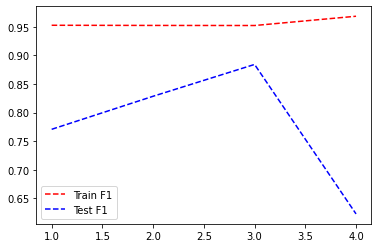

In [ ]:
f1_log_test = []
f1_log_train = []
acc_log_test = []
acc_log_train = []
pre_log_test = []
pre_log_train = []
re_log_test = []
re_log_train = []
x = XGB_x_train
y = y_train
print(x.shape)
print(y.shape)
kf = StratifiedKFold(n_splits=4, random_state=0, shuffle=True)
for train_index, test_index in kf.split(x,y):
    x_train, x_test = x.iloc[train_index,:], x.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    log = LogisticRegression(C = 9.01, penalty = 'elasticnet', solver = 'saga', class_weight= 'balanced', l1_ratio= 0.001)

    log.fit(x_train, y_train)
    predicted = log.predict(x_test)

    pred_train = log.predict(x_train)
    
    f1_test = metrics.f1_score(y_test, predicted, average = 'weighted')
    f1_train = metrics.f1_score(y_train, pred_train, average = 'weighted')

    acc_test = metrics.accuracy_score(y_test, predicted)
    acc_train = metrics.accuracy_score(y_train, pred_train)

    pre_test = metrics.precision_score(y_test, predicted, average = 'weighted')
    pre_train = metrics.precision_score(y_train, pred_train, average = 'weighted')

    re_test = metrics.recall_score(y_test, predicted, average = 'weighted')
    re_train = metrics.recall_score(y_train, pred_train, average = 'weighted')

    f1_log_test.append(f1_test)
    f1_log_train.append(f1_train)

    acc_log_test.append(acc_test)   
    acc_log_train.append(acc_train) 

    pre_log_test.append(pre_test)   
    pre_log_train.append(pre_train)

    re_log_test.append(re_test)   
    re_log_train.append(re_train)

print('F1_test',np.mean(f1_log_test))
print('F1_train', np.mean(f1_log_train))
print('Accuracy_test',np.mean(acc_log_test))
print('Accuracy_train', np.mean(acc_log_train))
print('Precision_test',np.mean(pre_log_test))
print('Precision_train', np.mean(pre_log_train))
print('Recall_test',np.mean(re_log_test))
print('Recall_train', np.mean(re_log_train))

log = {
    'Fold': pd.Series([1,2,3,4]),
    'Train_F1': pd.Series(f1_log_train),
    'Test_F1': pd.Series(f1_log_test)
}
log_fitting = pd.DataFrame(log)

plt.plot(log_fitting['Fold'], log_fitting['Train_F1'], 'r--', log_fitting['Fold'], log_fitting['Test_F1'], 'b--')
# plt.ylim((0.40,0.50))
plt.legend(['Train F1', 'Test F1'])
plt.show()

In [ ]:
Counter(y_train)

Counter({0: 14, 1: 25, 2: 15, 3: 23, 4: 29, 5: 15, 6: 16, 7: 14, 8: 17})

In [ ]:
Counter(LR.predict(XGB_x_train))

Counter({0: 13, 1: 29, 2: 14, 3: 24, 4: 32, 5: 14, 6: 17, 7: 8, 8: 17})

### RF

In [25]:
kappa = []
accuracy = []
f1 = []

#random forest
RF_x_train = x_train[RF_feature]
skFold = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)
for train_index, test_index in skFold.split(RF_x_train,y_train):
    X_train_split, X_test_split=RF_x_train.iloc[train_index,:], RF_x_train.iloc[test_index,:]
    y_train_split, y_test_split=y_train[train_index], y_train[test_index]
    LR = LogisticRegression(random_state=0,multi_class = 'multinomial',solver="newton-cg")
    LR.fit(X_train_split, y_train_split)
    kappa.append(cohen_kappa_score(y_test_split, LR.predict(X_test_split)))
    accuracy.append(accuracy_score(y_test_split, LR.predict(X_test_split)))
    f1.append(f1_score(y_test_split, LR.predict(X_test_split),average='micro'))
#input kappa, % correct, precision, and recall
print("kappa score: {}".format(np.mean(kappa)))
print("accuracy: {}".format(np.mean(accuracy)))
print("f1: {}".format(np.mean(f1)))
print("confusion matrix: \n{}".format(confusion_matrix(y_test, LR.predict(x_test[RF_feature]))))
print("classification report: \n{}".format(classification_report(y_test, LR.predict(x_test[RF_feature]))))

kappa score: 0.7754308283072896
accuracy: 0.8035714285714286
f1: 0.8035714285714286
confusion matrix: 
[[30  0  1  0  0  0 13  1  0]
 [ 0 86  4  3  0  0  2  2  0]
 [ 0  0 20  0  0  0  0  1  0]
 [ 0 21  5 55  0  0  0 11  1]
 [ 0  1  4  0 61  0  0  2 15]
 [ 0  1  0  0  1 12  0  0  0]
 [ 1  0  0  0  0  0 43  0  1]
 [ 0  3  3  2  5  0  0  7  0]
 [ 0  0  1  0 10  0  5  0 73]]
classification report: 
              precision    recall  f1-score   support

           0       0.97      0.67      0.79        45
           1       0.77      0.89      0.82        97
           2       0.53      0.95      0.68        21
           3       0.92      0.59      0.72        93
           4       0.79      0.73      0.76        83
           5       1.00      0.86      0.92        14
           6       0.68      0.96      0.80        45
           7       0.29      0.35      0.32        20
           8       0.81      0.82      0.82        89

    accuracy                           0.76       507
   mac

In [ ]:
log = LogisticRegression()
log_pa = {
    'penalty': ['l1',' l2', 'elasticnet'],
    'C': np.arange(0.01,31),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'class_weight': ['balanced', None],
    'l1_ratio': [0.001,0.01,0.1]
    # 'max_iter': np.arange(100,1100000,10000)
}

log_grid = GridSearchCV(log, log_pa, cv = 4, scoring = 'f1_weighted')
log_grid.fit(RF_x_train,y_train)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/us

GridSearchCV(cv=4, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.000e-02, 1.010e+0...
       1.801e+01, 1.901e+01, 2.001e+01, 2.101e+01, 2.201e+01, 2.301e+01,
       2.401e+01, 2.501e+01, 2.601e+01, 2.701e+01, 2.801e+01, 2.901e+01,
       3.001e+01]),
                         'class_weight': ['balanced', None],
                         'l1_ratio': [0.001, 0.01, 0.1],
        

In [ ]:
print('Best cv accuracy: {}' .format(log_grid.best_score_))
print('Test set score:   {}' .format(log_grid.score(RF_x_train,y_train)))
print('Best parameters:  {}' .format(log_grid.best_params_))

Best cv accuracy: 0.8124384048491191
Test set score:   0.9162070727460512
Best parameters:  {'C': 2.01, 'class_weight': None, 'l1_ratio': 0.001, 'penalty': 'elasticnet', 'solver': 'saga'}


(168, 109)
(168,)
F1_test 0.7903073282537568
F1_train 0.9343671658739024
Accuracy_test 0.7976190476190477
Accuracy_train 0.9345238095238095
Precision_test 0.8093726379440664
Precision_train 0.9370477163963638
Recall_test 0.7976190476190477
Recall_train 0.9345238095238095


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


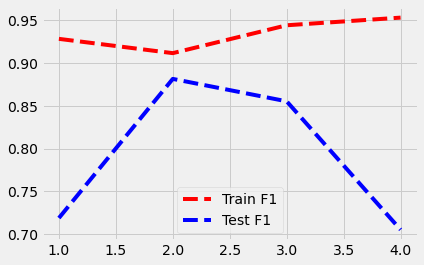

In [ ]:
f1_log_test = []
f1_log_train = []
acc_log_test = []
acc_log_train = []
pre_log_test = []
pre_log_train = []
re_log_test = []
re_log_train = []
x = RF_x_train
y = y_train
print(x.shape)
print(y.shape)
kf = StratifiedKFold(n_splits=4, random_state=0, shuffle=True)
for train_index, test_index in kf.split(x,y):
    x_train, x_test = x.iloc[train_index,:], x.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    log = LogisticRegression(C = 3.01, penalty = 'l1', solver = 'liblinear', class_weight= 'balanced', l1_ratio= 0.001)

    log.fit(x_train, y_train)
    predicted = log.predict(x_test)

    pred_train = log.predict(x_train)
    
    f1_test = metrics.f1_score(y_test, predicted, average = 'weighted')
    f1_train = metrics.f1_score(y_train, pred_train, average = 'weighted')

    acc_test = metrics.accuracy_score(y_test, predicted)
    acc_train = metrics.accuracy_score(y_train, pred_train)

    pre_test = metrics.precision_score(y_test, predicted, average = 'weighted')
    pre_train = metrics.precision_score(y_train, pred_train, average = 'weighted')

    re_test = metrics.recall_score(y_test, predicted, average = 'weighted')
    re_train = metrics.recall_score(y_train, pred_train, average = 'weighted')

    f1_log_test.append(f1_test)
    f1_log_train.append(f1_train)

    acc_log_test.append(acc_test)   
    acc_log_train.append(acc_train) 

    pre_log_test.append(pre_test)   
    pre_log_train.append(pre_train)

    re_log_test.append(re_test)   
    re_log_train.append(re_train)

print('F1_test',np.mean(f1_log_test))
print('F1_train', np.mean(f1_log_train))
print('Accuracy_test',np.mean(acc_log_test))
print('Accuracy_train', np.mean(acc_log_train))
print('Precision_test',np.mean(pre_log_test))
print('Precision_train', np.mean(pre_log_train))
print('Recall_test',np.mean(re_log_test))
print('Recall_train', np.mean(re_log_train))

log = {
    'Fold': pd.Series([1,2,3,4]),
    'Train_F1': pd.Series(f1_log_train),
    'Test_F1': pd.Series(f1_log_test)
}
log_fitting = pd.DataFrame(log)

plt.plot(log_fitting['Fold'], log_fitting['Train_F1'], 'r--', log_fitting['Fold'], log_fitting['Test_F1'], 'b--')
# plt.ylim((0.40,0.50))
plt.legend(['Train F1', 'Test F1'])
plt.show()

In [ ]:
Counter(y_train)

Counter({0: 14, 1: 25, 2: 15, 3: 23, 4: 29, 5: 15, 6: 16, 7: 14, 8: 17})

In [ ]:
Counter(LR.predict(RF_x_train))

Counter({0: 13, 1: 29, 2: 14, 3: 22, 4: 32, 5: 14, 6: 17, 7: 11, 8: 16})

In [ ]:
res = pd.DataFrame(columns=('Train F1', 'Test F1'))
res = res.append([{'i':i}], ignore_index=True)
res = res.append([{'Train F1':np.mean(f1_log_train)}], ignore_index=True)
res = res.append([{'Test F1':np.mean(f1_log_test)}], ignore_index=True)

# RF model with XGBOOST feature selection


kappa score: 0.8304204912448898
accuracy: 0.8511904761904762
precision: 0.8728941197691197
recall: 0.8511904761904762
f1: 0.8490483061911633
RF               precision    recall  f1-score   support

    asphalt        0.94      0.76      0.84        45
   building        0.78      0.74      0.76        97
        car        0.43      0.95      0.60        21
   concrete        0.85      0.72      0.78        93
      grass        0.65      0.95      0.77        83
       pool        0.85      0.79      0.81        14
     shadow        0.79      0.91      0.85        45
       soil        0.59      0.50      0.54        20
       tree        0.94      0.54      0.69        89

    accuracy                           0.75       507
   macro avg       0.76      0.76      0.74       507
weighted avg       0.80      0.75      0.75       507



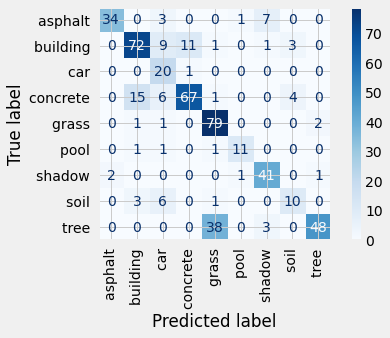

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold
XGB_x_test = x_test[XGB_feature['index']]
X_train = XGB_x_train
y_train = y_train
kappa = []
accuracy = []
precision = []
recall = []
f1 = []
#using 4-fold cross-validation
skFold = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)
for train_index, test_index in skFold.split(X_train,y_train):
    X_train_split, X_test_split=X_train.iloc[train_index,:], X_train.iloc[test_index,:]
    y_train_split, y_test_split=y_train[train_index], y_train[test_index]
    RF = RandomForestClassifier(random_state=0, min_samples_leaf = 4, 
                             min_samples_split = 10)
    RF.fit(X_train_split, y_train_split)
    kappa.append(cohen_kappa_score(y_test_split, RF.predict(X_test_split)))
    accuracy.append(accuracy_score(y_test_split, RF.predict(X_test_split)))
    precision.append(precision_score(y_test_split, RF.predict(X_test_split),average = 'weighted'))
    recall.append(recall_score(y_test_split, RF.predict(X_test_split),average = 'weighted'))
    f1.append(f1_score(y_test_split, RF.predict(X_test_split),average = 'weighted'))
#input kappa, % correct, precision, and recall
print("kappa score: {}".format(np.mean(kappa)))
print("accuracy: {}".format(np.mean(accuracy)))
print("precision: {}".format(np.mean(precision)))
print("recall: {}".format(np.mean(recall)))
print("f1: {}".format(np.mean(f1)))
print("RF", classification_report(y_test, RF.predict(XGB_x_test)))
print(plot_confusion_matrix(RF, XGB_x_test, y_test,cmap=plt.cm.Blues,xticks_rotation = 'vertical'))

# GradientBoostingClassifier with XGBoost feature selected

kappa score: 0.7616894437236911
accuracy: 0.7916666666666666
precision: 0.8270382395382395
recall: 0.7916666666666666
f1: 0.7871875965860928
GB               precision    recall  f1-score   support

    asphalt        0.95      0.40      0.56        45
   building        0.81      0.45      0.58        97
        car        0.26      0.95      0.41        21
   concrete        0.71      0.81      0.76        93
      grass        0.56      0.92      0.70        83
       pool        1.00      0.86      0.92        14
     shadow        0.93      0.87      0.90        45
       soil        0.24      0.25      0.24        20
       tree        0.88      0.42      0.56        89

    accuracy                           0.64       507
   macro avg       0.71      0.66      0.63       507
weighted avg       0.75      0.64      0.65       507



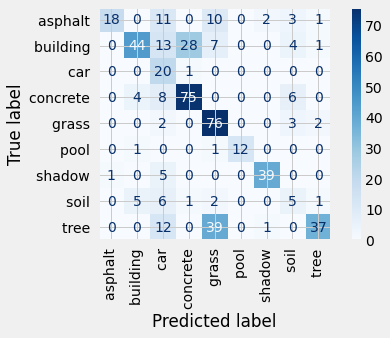

In [46]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold
X_train = XGB_x_train
y_train = y_train
kappa = []
accuracy = []
precision = []
recall = []
f1 = []
#using 4-fold cross-validation
skFold = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)
for train_index, test_index in skFold.split(X_train,y_train):
    X_train_split, X_test_split=X_train.iloc[train_index,:], X_train.iloc[test_index,:]
    y_train_split, y_test_split=y_train[train_index], y_train[test_index]
    GB = GradientBoostingClassifier(min_samples_leaf = 4, min_samples_split = 10, 
                                    learning_rate = 0.01, random_state = 0, 
                                    max_depth = 5, n_estimators = 100, subsample = 1.0)
    GB.fit(X_train_split, y_train_split)
    kappa.append(cohen_kappa_score(y_test_split, GB.predict(X_test_split)))
    accuracy.append(accuracy_score(y_test_split, GB.predict(X_test_split)))
    precision.append(precision_score(y_test_split, GB.predict(X_test_split),average = 'weighted'))
    recall.append(recall_score(y_test_split, GB.predict(X_test_split),average = 'weighted'))
    f1.append(f1_score(y_test_split, GB.predict(X_test_split),average = 'weighted'))
#input kappa, % correct, precision, and recall
print("kappa score: {}".format(np.mean(kappa)))
print("accuracy: {}".format(np.mean(accuracy)))
print("precision: {}".format(np.mean(precision)))
print("recall: {}".format(np.mean(recall)))
print("f1: {}".format(np.mean(f1)))
print("GB", classification_report(y_test, GB.predict(XGB_x_test)))
print(plot_confusion_matrix(GB, XGB_x_test, y_test,cmap=plt.cm.Blues,xticks_rotation = 'vertical'))

# results


In [ ]:
chi2_x_train.columns

Index(['Area', 'Bright', 'Mean_G', 'Mean_R', 'Mean_NIR', 'NDVI', 'Bright_40',
       'Mean_G_40', 'Mean_R_40', 'Mean_NIR_40', 'NDVI_40', 'Bright_60',
       'Mean_G_60', 'Mean_R_60', 'Mean_NIR_60', 'SD_G_60', 'NDVI_60',
       'Bright_80', 'Mean_G_80', 'Mean_R_80', 'Mean_NIR_80', 'SD_G_80',
       'Bright_100', 'Mean_G_100', 'Mean_R_100', 'Mean_NIR_100', 'SD_G_100',
       'Bright_120', 'Mean_G_120', 'Mean_R_120', 'Mean_NIR_120', 'SD_G_120',
       'Bright_140', 'Mean_G_140', 'Mean_R_140', 'Mean_NIR_140', 'SD_G_140'],
      dtype='object')

In [ ]:
XGB_x_train.columns

Index(['NDVI_40', 'NDVI', 'NDVI_60', 'Mean_R_40', 'BordLngth_60',
       'Mean_NIR_80', 'BrdIndx_80', 'Mean_NIR', 'ShpIndx_60', 'Area_40',
       'Mean_NIR_120', 'Bright', 'Dens_80', 'Compact_80', 'Mean_G',
       'BrdIndx_60', 'Bright_80', 'GLCM1', 'Mean_G_40', 'Compact_120',
       'Mean_R', 'Mean_G_60', 'Compact', 'Dens_40', 'Round_60', 'GLCM2',
       'SD_R_40', 'Mean_R_80', 'SD_G', 'ShpIndx_120', 'BrdIndx_120', 'BrdIndx',
       'Mean_NIR_40', 'SD_NIR', 'Compact_100', 'GLCM2_80', 'SD_G_40',
       'BordLngth_80', 'SD_G_80', 'Mean_G_80', 'Rect_40', 'GLCM3_80', 'Area'],
      dtype='object')

In [ ]:
RF_x_train.columns

Index(['Compact', 'ShpIndx', 'Mean_G', 'Mean_R', 'Mean_NIR', 'NDVI',
       'BordLngth', 'Bright_40', 'Compact_40', 'Mean_G_40', 'Mean_R_40',
       'Mean_NIR_40', 'SD_G_40', 'NDVI_40', 'BordLngth_40', 'BrdIndx_60',
       'Mean_G_60', 'Mean_R_60', 'NDVI_60', 'BordLngth_60', 'Mean_G_80',
       'Mean_R_80', 'Mean_NIR_80', 'SD_G_80', 'NDVI_80', 'BordLngth_80',
       'ShpIndx_100', 'Mean_G_100', 'Mean_R_100', 'Mean_NIR_100', 'SD_G_100',
       'GLCM2_100', 'NDVI_100', 'Mean_R_120', 'Mean_NIR_120', 'BordLngth_120',
       'BrdIndx_140', 'SD_G_140'],
      dtype='object')